In [2]:
from IPython.display import display, Javascript
from datetime import datetime
from utils.notebooks import get_date_slider_from_datetime
from ipywidgets import interact, Output, widgets, Layout
from ipywidgets.widgets import Dropdown

%store -r the_page
%store -r the_editor
%store -r agg_actions
%store -r editor_inputname
#%store -r calculator
%store -r editors_conflicts
%store -r sources

# if ('the_page' not in locals() or 
#     'the_editor' not in locals() or 
#     'agg_actions' not in locals() or 
#     'editor_inputname' not in locals() or 
#     'calculator' not in locals() or 
#     'editors_conflicts' not in locals()):
    
#     import pickle
#     print("Loading default data...")
#     the_page = pickle.load(open("data/the_page.p",'rb'))
#     the_editor = pickle.load(open("data/the_editor.p",'rb'))
#     agg_actions = pickle.load(open("data/agg_actions.p",'rb'))
#     editor_inputname = pickle.load(open("data/editor_inputname.p",'rb'))
#     calculator = pickle.load(open("data/calculator.p",'rb'))
#     editors_conflicts = pickle.load(open("data/editors_conflicts.p",'rb'))

display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
summary{
    display:list-item;
}

.widget-radio-box{
    flex-direction: row;
}

.widget-radio-box input{
    margin:0 6px 0 5px
}
</style>

In [4]:
%%capture

%load_ext autoreload
%autoreload 2

### <span style="color:green"> Modules Imported </span>

In [5]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output
from datetime import date
import urllib

# APIs
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI
from external.wikimedia import WikiMediaDV, WikiMediaAPI
from external.xtools import XtoolsAPI, XtoolsDV

# Data Processing
import pickle
import pandas as pd

# Visualization tools
import qgrid
import matplotlib.pyplot as plt

# Page views timeline
from visualization.views_listener import ViewsListener

# Change actions timeline
from visualization.actions_listener import ActionsListener

# Conflicts visualization
from visualization.conflicts_listener import ConflictsListener, ConflictsActionListener
from visualization.calculator_listener import ConflictCalculatorListener

# Word cloud visualization
from visualization.wordcloud_listener import WCListener, WCActionsListener
from visualization.wordclouder import WordClouder

# Wikipedia talk pages visualization
from visualization.talks_listener import TalksListener
from visualization.topics_listener import TopicsListener

# Tokens ownership visualization
from visualization.owned_listener import OwnedListener

# To remove stopwords
from visualization.editors_listener import remove_stopwords

# Metrics management
from metrics.conflict import ConflictManager
from metrics.token import TokensManager

# For language selection
from utils.lngselection import abbreviation, lng_listener

# Load the variables stored in the last notebook
%store -r the_page
%store -r total_actions
#%store -r conflict_calculator
#%store -r conflicts_by_editors
%store -r editor_info
%store -r editor_input_id
%store -r lng_selected
%store -r con_manager_all
%store -r sources

# # Check them if in the namespace, otherwise load the default data.
# if ('the_page' not in locals() or 
#     'total_actions' not in locals() or 
#     'conflict_calculator' not in locals() or 
#     'conflicts_by_editors' not in locals() or
#     'editor_info' not in locals() or
#     'editor_input_id' not in locals()):
    
#     print("Loading default data...")
#     the_page = pickle.load(open("data/the_page.p",'rb'))
#     total_actions = pickle.load(open("data/agg_actions.p",'rb'))
#     conflict_calculator = pickle.load(open("data/calculator.p",'rb'))
#     conflicts_by_editors = pickle.load(open("data/editors_conflicts.p",'rb'))
#     editor_info = pickle.load(open("data/the_editor.p",'rb'))
#     editor_input_id = pickle.load(open("data/editor_inputname.p",'rb'))

In [6]:
display(md(f"# ***Page: {the_page['title']} ({lng_selected.upper()})***"))

# ***Page: The Camp of the Saints (EN)***

---

# A.  Select an editor to analyze their conflicting editors

The table below presents the conflict score and other related  metrics per editor 
(*editor_id* and *editor* column). Select one editor to analyze the editors that enter into 
conflict with her:

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **conflicts**: the total number of conflicts
- **elegibles**: the total number of elegible actions performed by the editor
- **conflict**: the sum of conflict scores of all actions divided by the number of elegible actions
</details>

In [7]:
def display_conflict_score(eleg_actions):
    global listener
    
    
    listener = ConflictCalculatorListener(eleg_actions)

    metrics = ['Conflict Score', 'Absolute Conflict Score', 
               'Conflict Ratio',  'Number of Conflicts', 
               'Total Elegible Actions', 
               'Total Conflict Time', 'Total Elegible Time', 
               'Time per Conflict Action', 'Time per Elegible Action']

    #display(md(f'*Total Page conflict score: {calculator.get_page_conflict_score()}*'))

    # Visualization

    interact(listener.listen,
             #_range = get_date_slider_from_datetime(eleg_actions['rev_time']),
             _range1=widgets.DatePicker(description='Date starts', value=eleg_actions.sort_values('rev_time')['rev_time'].iloc[0], layout=Layout(width='25%')),
             _range2=widgets.DatePicker(description='Date ends', value=eleg_actions.sort_values('rev_time')['rev_time'].iloc[-1], layout=Layout(width='25%')),
             granularity=Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Daily'),
             black=Dropdown(options=metrics, value='Conflict Score'),
             red=Dropdown(options= ['None'] + metrics, value='None'))

def select_editor(editor):
    global editor_df
    global the_editor
    global editor_inputname

    editor_inputname=editor
    
    wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))
    try:
        the_editor = wikipedia_dv.get_editor(int(editor_inputname))
    except:
        the_editor = wikipedia_dv.get_editor(editor_inputname[2:])

    with out:
        %store the_editor
        %store editor_inputname

        clear_output()
        display(md("### Current Selection:"))
        
        url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_inputname}&usprop=blockinfo|editcount|registration|gender&format=json'
        print("Editor's metadata can be found in:")
        print(url)
        if 'invalid' in the_editor:
            display(f"The editor {editor_inputname} was not found, try a different editor")
        else:
            # display the data that will be passed to the next notebook
            display(the_editor.to_frame('values'))
            display(md(f"#### Evolution of the Conflict Score of *{the_editor['name']}*"))
            
            elegible_actions = remove_stopwords(sources['elegibles_all'], lng=lng_selected)

            editor_df = elegible_actions[
                elegible_actions['editor'] == str(editor_inputname)].copy()

            display_conflict_score(editor_df)


def on_selection_change(change):

    try:
        select_editor(qg_obj.get_selected_df().iloc[0].name)
    except:
        print('Problem parsing the name. Execute the cell again and try a different editor.')


qgrid.set_grid_option('maxVisibleRows', 5)
qg_obj = qgrid.show_grid(editors_conflicts)
qg_obj.observe(on_selection_change, names=['_selected_rows'])
                       
display(md("### Select one editor (row) to continue the demo:"))
display(md('**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*'))
display(qg_obj)
out = Output()
display(out)

select_editor(editor_inputname)

### Select one editor (row) to continue the demo:

**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Output()

In the above graph you can select the *date range* and *granularity* (yearly, montly) 
of the timeline (X-axis), and plot any of the following counts in the black and red lines:

<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>
    
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions
- **Number of Conflicts**: the total number of conflicts
- **Total Elegible Actions**: the total number of elegible actions
- **Total Conflict Time**: the sum of all the time (*time_diff_secs*) that has been taken by conflict actions
- **Total Elegible Time**: the sum of all the time (*time_diff_secs*) that has been taken by elegible actions
- **Time per Conflict Action**: average time of conflict actions
- **Time per Elegible Action**: average time of elegible actions
</details>

<span style="color: #626262"> Try yourself! This is what will happen when you select an editor: </span>

In [8]:
### ----------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR  ###
### ----------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')

## Use the variable from the last notebook: conflicts_by_editors (pd.DataFrame)        ##
## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
qgrid.set_grid_option('maxVisibleRows', 5)
qgrid_init = qgrid.show_grid(editors_conflicts)
display(qgrid_init)

## Get the editor info with Wikipedia API (get_editor() method), more details you could check: ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/api.py                        ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py                  ##
wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))

# This is an example editor index. You could change it manully by typing in a new index from
# the above grid, e.g. 737021
editor_input_id = editors_conflicts.index[1]

# Get the editor's information in the form of pd.DataFrame
editor_info = wikipedia_dv.get_editor(int(editor_input_id))

## Display the basic information of the selected editor ##
editor_url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_input_id}&usprop=blockinfo|editcount|registration|gender&format=json'
print("Editor's metadata can be found in:")
print(editor_url)
display(md("### Current Selection:"))
display(editor_info.to_frame('values'))

## Interactive evolution of conflict score of this editor, using ConflictCalculatorListener, more details see ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/calculator_listener.py                  ##
display(md(f"#### Evolution of the Conflict Score of *{editor_info['name']}*"))

# Dataframe containing the elegible actions info of the editor for interactive.
elegibleActions = remove_stopwords(sources["elegibles_all"], lng=lng_selected)
editor_df = elegibleActions[elegibleActions['editor'] == str(editor_input_id)].copy()
           
# Create a ConflictCalculatorListener instance.
conflicts_cal_listener = ConflictCalculatorListener(editor_df)

# Set parameters.
begin_date = date(2005, 3, 1)
end_date = date(2019, 6, 1)
frequency = 'Daily' # 'Monthly', 'Daily'

# The metrics we need:
# ['Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', 'Number of Conflicts',
#  'Total Elegible Actions', 'Total Conflict Time', 'Total Elegible Time', 
# 'Time per Conflict Action', 'Time per Elegible Action', ('None')]
# Note: only 'red_line' has 'None' option.
black_line = 'Conflict Score'
red_line = 'None'
           
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
           
conflicts_cal_listener.listen(
    _range1 = begin_date,
    _range2 = end_date,
    granularity = frequency,
    black = black_line,
    red = red_line
)
           
# store the editor_input_id and editor_info for the usage in next notebook.
%store editor_input_id
%store editor_info

The page that is being used: The Camp of the Saints (EN)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Editor's metadata can be found in:
https://en.wikipedia.org/w/api.php?action=query&list=users&ususerids=1413513&usprop=blockinfo|editcount|registration|gender&format=json


### Current Selection:

,values
userid,1413513
name,KleenupKrew
editcount,1323
registration,2006-05-10T16:13:03Z
gender,unknown


#### Evolution of the Conflict Score of *KleenupKrew*

Time range from 2005-03-01 to 2019-06-01


Stored 'editor_input_id' (int64)
Stored 'editor_info' (Series)


---

# B. Detecting conflicting editors

In [9]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

If the editor undo the action of editor B, editor B is called 
a conflicting editor. The following table shows the conflicting editors including their conflict score and other related metrics (see section A).

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **conflict_n**: the total number of conflicts
- **conflict**: the sum of conflict scores of all actions (without division)
- **actions**: the total number of actions performed by the editor
- **conflict_score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **conflict_ratio**: the count of all conflicts divided by the number of elegible actions

In [10]:
# create and display the button
button1 = widgets.Button(description="Show Conflicting Editors", layout=Layout(width='180px'))
display(button1)

def on_click_detect(b):
    global editors
    global conflicting_actions
    with out1:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        conflicting_actions = con_manager_all.get_conflicting_actions(str(editor_inputname))
        conflicting_actions = remove_stopwords(conflicting_actions, lng=lng_selected)

        wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))

        conflicting_editors = conflicting_actions['editor'].unique().tolist()

        editors = wikipedia_dv.get_editors([int(x) for x in conflicting_editors if x[:2] != '0|'])
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            editors['userid'] = editors['userid'].astype('str')
            full_editors_conflicts = con_manager_all.get_conflict_score_per_editor()
            display(editors[['userid','name','registration']].merge( full_editors_conflicts, 
                            right_index=True, left_on='userid',how='left').set_index('userid'))
                   
                   
out1 = Output()
display(out1)

# set the event
button1.on_click(on_click_detect)

# trigger the event with the default value
on_click_detect(button1)

Button(description='Show Conflicting Editors', layout=Layout(width='180px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Conflicting Editors' button: </span>

In [11]:
### ---------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Conflicting Editors' BUTTON  ###
### ---------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])

## Get the conflicting editors ##

# Get all conflcting actions of all editors through the instance 'conflict_calculator'
# created in the second notebook. Use the 'get_conflicting_actions()' method.
all_conflict_actions = con_manager_all.get_conflicting_actions(str(editor_input_id))
all_conflict_actions = remove_stopwords(all_conflict_actions, lng=lng_selected)

# Get a list of conflicting editors.
all_conflict_editors = all_conflict_actions['editor'].unique().tolist()

# Eliminate the unregistered editors
final_editors = wikipedia_dv.get_editors([int(x) for x in all_conflict_editors if x[:2] != '0|'])

# Check if the conflicting editor's list is empty.
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    final_editors['userid'] = final_editors['userid'].astype('str')
    
    # Conflict score for every editor.
    all_editors_conflicts = con_manager_all.get_conflict_score_per_editor()
    
    # Integrate conflicting information into the editors' basic info table. 
    display(final_editors[['userid','name','registration']].merge(all_editors_conflicts, 
                             right_index=True, left_on='userid', how='left').set_index('userid'))

The page that is being used: The Camp of the Saints (EN)
Selected editor: KleenupKrew


,name,registration,conflict_n,conflict,action,conflict_score,conflict_ratio
userid,,,,,,,
85879,User2004,2004-07-13T08:00:40Z,70,68.904926,70,0.984356,1.0


---

# C. Activity of conflicting editors

In [12]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

In the following graph you can select the conflicting *editor*, *date range* and 
*granularity* (yearly, montly) of the timeline (X-axis), and plot any of the follow counts in 
the black, red, blue and green lines:


<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>

- **adds**: number of first-time insertions
- **adds_surv_48h**: number of insertions for the first time that survived at least 48 hours
- **adds_persistent**:  number of insertions for the first time that survived until, at least, the end of the month
- **adds_stopword_count**:  number of insertions that were stop words
- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_persistent**: number of deletions that were not resinserted until, at least, the end of the month
- **dels_stopword_count**: number of deletions that were stop words
- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertionsthat survived at least 48 hours
- **reins_persistent**: number of reinsertionsthat survived until the end of the month
- **reins_stopword_count**: number of reinsertionsthat were stop words

In [13]:
# create and display the button
button2 = widgets.Button(description="Show Conflicting Editors Activities", layout=Layout(width='230px'))
display(button2)

def on_click_con_editor_act(b):
    global editors
    global conf_editor_agg_actions
    with out2:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            editors['userid'] = editors['userid'].astype('int')
            conf_editor_agg_actions = editors[['userid','name','registration']].merge(agg_actions, 
                     left_on='userid', right_on='editor_id', how='left').set_index('userid')

            # Listener
            listener = ActionsListener(sources, lng=lng_selected)
            listener.actions_one_editor = conf_editor_agg_actions
            actions = (conf_editor_agg_actions.loc[:,'total':'total_stopword_count'].columns.append(
                conf_editor_agg_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()

            # Visualization
            interact(listener.actions_listen, 
                     #_range = get_date_slider_from_datetime(conf_editor_agg_actions['year_month']),
                     _range1=widgets.DatePicker(description='Date starts', value=conf_editor_agg_actions.sort_values('rev_time')['rev_time'].iloc[0], layout=Layout(width='25%')),
                     _range2=widgets.DatePicker(description='Date ends', value=conf_editor_agg_actions.sort_values('rev_time')['rev_time'].iloc[-1], layout=Layout(width='25%')),
                     editor=Dropdown(options=['All'] + editors['name'].values.tolist(), value='All'),
                     granularity=Dropdown(options=['Yearly', 'Monthly', "Weekly", "Daily"], value='Monthly'),
                     black=Dropdown(options=actions, value='total'), 
                     red=Dropdown(options= ['None'] + actions, value='total_surv_48h'),
                     green=Dropdown(options= ['None'] + actions, value='None'), 
                     blue=Dropdown(options= ['None'] + actions, value='None'))

out2 = Output()
display(out2)

# set the event
button2.on_click(on_click_con_editor_act)

# trigger the event with the default value
on_click_con_editor_act(button2)

Button(description='Show Conflicting Editors Activities', layout=Layout(width='230px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Conflicting Editors Activities' button: </span>

In [14]:
### ----------------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Conflicting Editors Activities' BUTTON    ###
### ----------------------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])

## First check if the list is empty. ##
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    print('Available Conflicting Editors:', final_editors['name'].tolist())
    
    ## Merge editors' total actions information into 'final_editors' table. ##
    final_editors['userid'] = final_editors['userid'].astype('int')
    conf_editor_total_actions = final_editors[['userid','name','registration']].merge(total_actions, 
                                             left_on='userid', right_on='editor_id', how='left').set_index('userid')
    
    ## Visualization, core visual code lies in ActionsListener, then the interact function    ##
    ## make it interactive, mode details see:                                                 ##
    ## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py ##
    
    # Create an ActionsListener instance.
    actionslistener = ActionsListener(sources, lng=lng_selected)
    actionslistener.actions_one_editor = conf_editor_total_actions
    
    # What types of these actions?
    actions_types = (conf_editor_total_actions.loc[:,'total':'total_stopword_count'].columns.append(
                        conf_editor_total_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()
    
    # Visualization: try yourself by coding!
    begin_date = date(2002, 3, 1)
    end_date = date(2019, 4, 1)
    editor_name = 'All' # Select one conflicting name from the above name list, or 'All'!
    frequency = 'Monthly' # 'Yearly', 'Monthly', 'Weekly', 'Daily'
    black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
    red_line = 'dels'
    blue_line = 'None'
    green_line = 'None'
    
    print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
    print("Current editor's name is", editor_name)
    
    actionslistener.actions_listen(
        _range1 = begin_date,
        _range2 = end_date,
        editor = editor_name,
        granularity = frequency,
        black = black_line,
        red = red_line,
        blue = blue_line,
        green = green_line)

The page that is being used: The Camp of the Saints (EN)
Selected editor: KleenupKrew
Available Conflicting Editors: ['User2004']
Time range from 2002-03-01 to 2019-04-01
Current editor's name is All


---

# D. Tokens of conflicting editors

In [15]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

The WordCloud displays the most common token strings (words) that a particular editor 
inserted or deleted and that enter into conflict with other editors. The size of the token string in 
the WordCloud indicates frequency of actions.

In the controls, you can select the conflicting *editor*, the *date range*, the type of *action* 
(insertion or deletion), and the *source*.


<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>
    
-   **Only Conflicts**: use only the actions that are in conflict
-   **All Undos**: use all actions that involve and undo <mark> *Question: Should it be "Elegible Actions?"* </mark>
</details>

In [16]:
# create and display the button
button3 = widgets.Button(description="Show Tokens of Conflicting Editors", layout=Layout(width='250px'))
display(button3)

def on_click_token_conflict(b):
    global listener
    with out3:
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            clear_output()
            display(md(f"***Editor: {the_editor['name']}***"))

            # listener
            listener = WCListener(sources={"tokens_source": sources}, lng=lng_selected, specific_editor=str(editor_inputname), conflict_editor=editors)
            actions_all = remove_stopwords(sources["tokens_all"], lng=lng_selected)
            # visualization
            interact(listener.listen, 
                     #_range=get_date_slider_from_datetime(editor_conflicts['rev_time']),
                     _range1=widgets.DatePicker(description='Date starts', value=actions_all.sort_values('rev_time')['rev_time'].iloc[0], layout=Layout(width='25%')),
                     _range2=widgets.DatePicker(description='Date ends', value=actions_all.sort_values('rev_time')['rev_time'].iloc[-1], layout=Layout(width='25%')),
                     editor=Dropdown(options=['All']  + editors['name'].values.tolist(), value='All', layout={'width': '400px'}),
                     source=Dropdown(options=['Elegible Actions', 'Only Conflicts'], value= 'Elegible Actions', layout={'width': '400px'}),
                     action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', layout={'width': '400px'}),
                     stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'}))

out3 = Output()
display(out3)

# set the event
button3.on_click(on_click_token_conflict)

# trigger the event with the default value
on_click_token_conflict(button3)

Button(description='Show Tokens of Conflicting Editors', layout=Layout(width='250px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Tokens of Conflicting Editors' button: </span>

The page that is being used: The Camp of the Saints (EN)
Selected editor: KleenupKrew
Available Conflicting Editors: ['User2004']
Time range from 2002-03-01 to 2019-07-04
Current editor's name is All


**Only top 100 most frequent conflicting words displayed.**

### The below token conflicts ocurred in a total of 131 revisions:

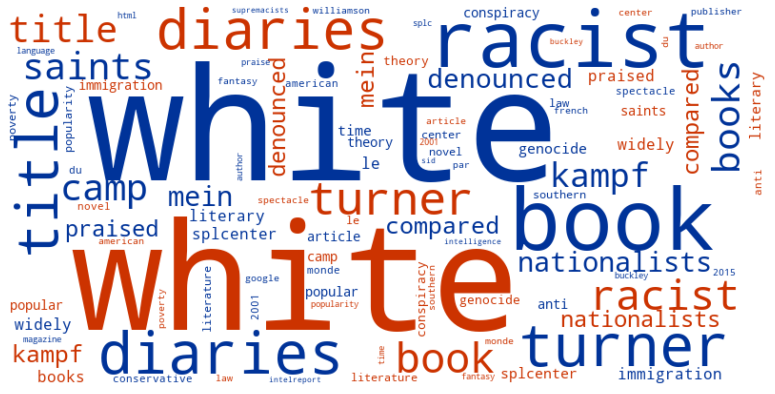

In [17]:
### ---------------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Tokens of Conflicting Editors' BUTTON ###
### ---------------------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])

## First check if the list is empty. ##
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    print('Available Conflicting Editors:', final_editors['name'].tolist())
    
    ## WordCloud, core visual code lies in WCListener, then the interact function               ##
    ## make it interactive, mode details see:                                                   ##
    ## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##

    # Create a WCListener instance
    wclistener = WCListener(sources={"tokens_source": sources}, lng=lng_selected, specific_editor=str(editor_info['userid']), conflict_editor=final_editors)
    
    # Visualization: you could also perform it by coding!
    begin_date = date(2002, 3, 1)
    end_date = date(2019, 7, 4)
    editor='All' # Select one conflicting name from the above name list, or 'All'!
    actions_source='Elegible Actions' # 'Elegible Actions', 'Only Conflicts'
    action_type='Both' # 'Just Insertions', 'Just Deletions', 'Both'
    stopwords='Not included'  # 'Not included', 'Included'
    
    print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
    print("Current editor's name is", editor)
    
    wclistener.listen(
         _range1=begin_date, 
         _range2=end_date,
         source=actions_source,
         action=action_type,
         editor=editor,
         stopwords=stopwords)

In [19]:
from IPython.display import HTML
from utils.notebooks import get_next_notebook

display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))

scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script
"""
display(HTML(scroll_to_top))